# Import library

In [89]:
#Import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,accuracy_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
seed =45
% matplotlib inline

# Import data set

In [33]:
train = pd.read_csv('train.csv',na_values=-1)
test = pd.read_csv('test.csv',na_values=-1)
print('Number rows and columns:',train.shape)
print('Number rows and columns:',test.shape)

Number rows and columns: (595212, 59)
Number rows and columns: (892816, 58)


# Explore data set

In [ ]:
train.head(3).T

# Target varaiable

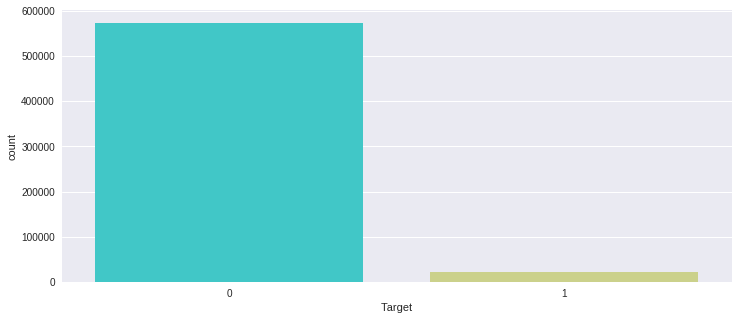

In [24]:
plt.figure(figsize=(12,5))
sns.countplot(train['target'],palette='rainbow')
plt.xlabel('Target')

The 'target' variable in imbalanced 

# CORELATION PLOT

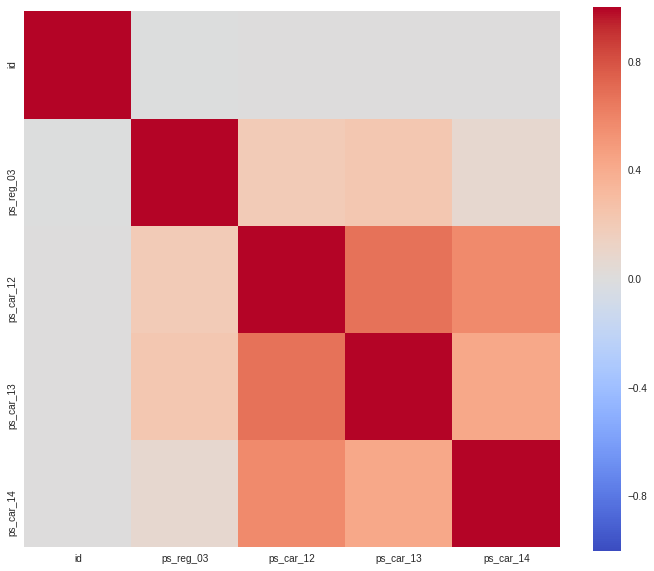

In [20]:
cor = train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor,square =True,cmap='coolwarm')

In [34]:
""" ps_calc value as 0 relation with remaining varialble"""
ps_cal = train.columns[train.columns.str.startswith('ps_calc')] 
train = train.drop(ps_cal,axis =1)
test = test.drop(ps_cal,axis=1)

# Missing value is data set

"""Values of -1 indicate that the feature was missing from the observation. 
The target columns signifies whether or not a claim was filed for that policy holder.""

In [88]:
k= pd.DataFrame()
k['train']= train.isnull().sum()
k['test'] = test.isnull().sum()
k.plot(kind='bar')

KeyboardInterrupt: 

Missing value in test train data set are in same propotion and same column

In [21]:
def uniq(df):
    col = df.columns
    for i in col:
        print('\n Unique value of "{}" is "{}" '.format(i,df[i].nunique()))               
        #print(df[i].unique())
uniq(train)


 Unique value of "id" is "595212" 

 Unique value of "target" is "2" 

 Unique value of "ps_ind_01" is "8" 

 Unique value of "ps_ind_02_cat" is "4" 

 Unique value of "ps_ind_03" is "12" 

 Unique value of "ps_ind_04_cat" is "2" 

 Unique value of "ps_ind_05_cat" is "7" 

 Unique value of "ps_ind_06_bin" is "2" 

 Unique value of "ps_ind_07_bin" is "2" 

 Unique value of "ps_ind_08_bin" is "2" 

 Unique value of "ps_ind_09_bin" is "2" 

 Unique value of "ps_ind_10_bin" is "2" 

 Unique value of "ps_ind_11_bin" is "2" 

 Unique value of "ps_ind_12_bin" is "2" 

 Unique value of "ps_ind_13_bin" is "2" 

 Unique value of "ps_ind_14" is "5" 

 Unique value of "ps_ind_15" is "14" 

 Unique value of "ps_ind_16_bin" is "2" 

 Unique value of "ps_ind_17_bin" is "2" 

 Unique value of "ps_ind_18_bin" is "2" 

 Unique value of "ps_reg_01" is "10" 

 Unique value of "ps_reg_02" is "19" 

 Unique value of "ps_reg_03" is "5012" 

 Unique value of "ps_car_01_cat" is "12" 

 Unique value of "ps_car

The unique value of "ps_car_11_cat" is maximum in the data set is 104

# Covert int/float varaible into category data

In [32]:
def category_type(df):
    cat_col = df.columns[df.columns.str.endswith('_cat')]
    bin_col
    print(col)
    for i in col:
        if df[i].nunique()<=104:
            df[i] = df[i].astype('category')
category_type(train)
category_type(test)

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')
Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')


# Univariate analysis

In [19]:
cat_col = train.select_dtypes(exclude=['category']).columns
print(cat_col)

Index(['id', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14'], dtype='object')


In [28]:
train['ps_reg_01'].value_counts()

0.9    194608
0.7     67897
0.8     60277
0.6     56243
0.4     53569
0.1     43192
0.3     40290
0.5     32341
0.2     25113
0.0     21682
Name: ps_reg_01, dtype: int64

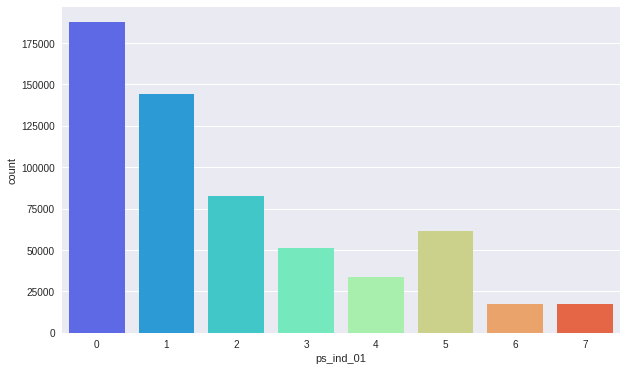

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(train['ps_ind_01'],palette='rainbow')


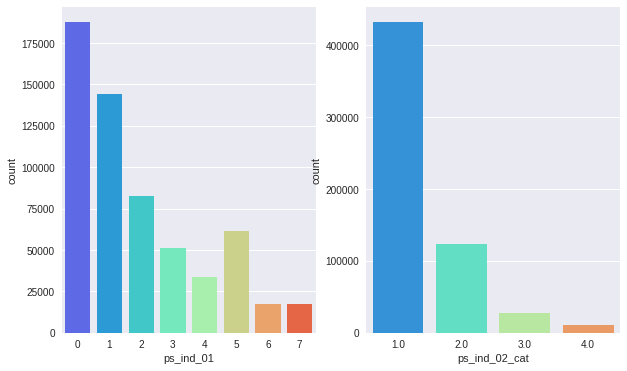

In [19]:
plt.figure(figsize=(10,6))
plt.subplot(121)
sns.countplot(train['ps_ind_01'],palette='rainbow')
plt.subplot(122)
sns.countplot(train['ps_ind_02_cat'],palette='rainbow')

# Replace missing value in numeric columns

In [ ]:
def missing_value(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [36]:
missing_value(train)
missing_value(test)

# Data set

In [37]:
X = train.drop(['target','id'],axis=1)
y = train['target']
x_test = test.drop('id',axis=1)

# Light GBM model

In [73]:
def runLGB(train,valid,y_train,y_valid,test,eta=0.5,num_rounds=10,early_stop=50,max_depth=5):
    
    param = {
            'objective':'binary',
            'boosting':'gbdt',
            'learning_rate':eta,            
            'metric':'auc',
            'bagging_fraction':0.7,
            #'bagging_freq':5,
            'bagging_seed':seed,
            'num_leaves':50,
            'feature_fraction':0.7,
            #'verbose':10,            
            'min_child_weight':6,
            'max_depth':max_depth,
            'reg_alpha':1.5, 
            'reg_lambda':5,
            'scale_pos_weight':9
        
            #'nthread':-1           
            }
   
    lgtrain = lgb.Dataset(train,label=y_train)
    lgvalid = lgb.Dataset(valid,label=y_valid)
    
    model=lgb.train(param,lgtrain,num_rounds,valid_sets=lgvalid,
              early_stopping_rounds=early_stop,verbose_eval=50 )
    #lg_pred = model.predict(xvl,num_iteration=model.best_iteration)
    pred = model.predict(test,num_iteration=model.best_iteration)    
    return pred,model

In [74]:
#Kfold
kf = StratifiedKFold(n_splits =10,random_state=seed,shuffle=True)
pred_test_full=0
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index], X.loc[test_index]
    ytr,yvl = y.loc[train_index], y.loc[test_index]
    
    pred_test,lg_model = runLGB(xtr,xvl,ytr,yvl,x_test,eta=0.1,num_rounds=500,max_depth=5)
    pred_test_full +=pred_test
    i+=1

1 of KFold 10
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.63475
[100]	valid_0's auc: 0.636184
[150]	valid_0's auc: 0.637224
[200]	valid_0's auc: 0.638632
[250]	valid_0's auc: 0.636841
Early stopping, best iteration is:
[217]	valid_0's auc: 0.639269
2 of KFold 10
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.635963
[100]	valid_0's auc: 0.636906
[150]	valid_0's auc: 0.638364
[200]	valid_0's auc: 0.637833
Early stopping, best iteration is:
[163]	valid_0's auc: 0.63925
3 of KFold 10
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.628802
[100]	valid_0's auc: 0.629169
[150]	valid_0's auc: 0.630897
[200]	valid_0's auc: 0.632118
[250]	valid_0's auc: 0.631772
Early stopping, best iteration is:
[214]	valid_0's auc: 0.633069
4 of KFold 10
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.644714
[100]	valid_0's auc: 0.647174
[150]	valid_0's auc: 0.6482

In [79]:
pred_lgb = pred_test_full/10

# Important Features

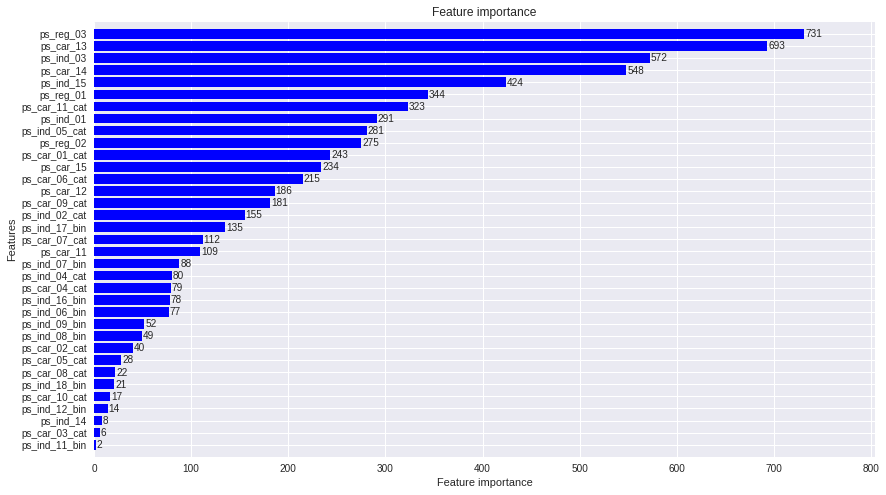

In [86]:
fig,ax = plt.subplots(figsize=(14,8))
lgb.plot_importance(lg_model,height=0.8,max_num_features=None,ax=ax,color='b')
plt.show()

# XGBoost

In [56]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.1,num_rounds=100,max_depth=4):
    params = {
        'objective':'binary:logistic',        
        'max_depth':max_depth,
        'learning_rate':eta,
        'eval_metric':'auc',
        'min_child_weight':6,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':seed,
        'reg_lambda':1.3,
        'reg_alpha':8,
        'gamma':10,
        'scale_pos_weight':1.6
        #'n_thread':-1
    }
    
    dtrain = xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,num_rounds,watchlist,early_stopping_rounds=500,verbose_eval=50)
    pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    return pred_test,model
    

In [81]:
kf = StratifiedKFold(n_splits=5,random_state=seed)
pred_test_full =0
cv_score = []
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    pred_test,xg_model = runXGB(xtr,xvl,ytr,yvl,x_test,num_rounds=500,eta=0.07)    
    pred_test_full += pred_test
    i+=1


1 of KFold 5
[0]	train-auc:0.587895	test-auc:0.58752
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[20]	train-auc:0.620098	test-auc:0.618474
[40]	train-auc:0.628227	test-auc:0.624293
[60]	train-auc:0.639387	test-auc:0.631506
[80]	train-auc:0.645112	test-auc:0.634595
[100]	train-auc:0.648218	test-auc:0.636478
[120]	train-auc:0.650968	test-auc:0.638049
[140]	train-auc:0.652941	test-auc:0.639083
[160]	train-auc:0.654569	test-auc:0.639786
[180]	train-auc:0.656209	test-auc:0.64019
[200]	train-auc:0.657146	test-auc:0.640451
[220]	train-auc:0.658052	test-auc:0.641044
[240]	train-auc:0.659424	test-auc:0.641394
[260]	train-auc:0.660509	test-auc:0.64136
[280]	train-auc:0.661264	test-auc:0.641257
[300]	train-auc:0.661823	test-auc:0.64151
[320]	train-auc:0.662348	test-auc:0.641676
[340]	train-auc:0.662782	test-auc:0.641711
[360]	train-auc:0.663535	test-auc:0.641749
[380]	train-auc:0.663946	test-auc:0.641

In [48]:
pred_xgb = pred_test_full/5

# Important Features

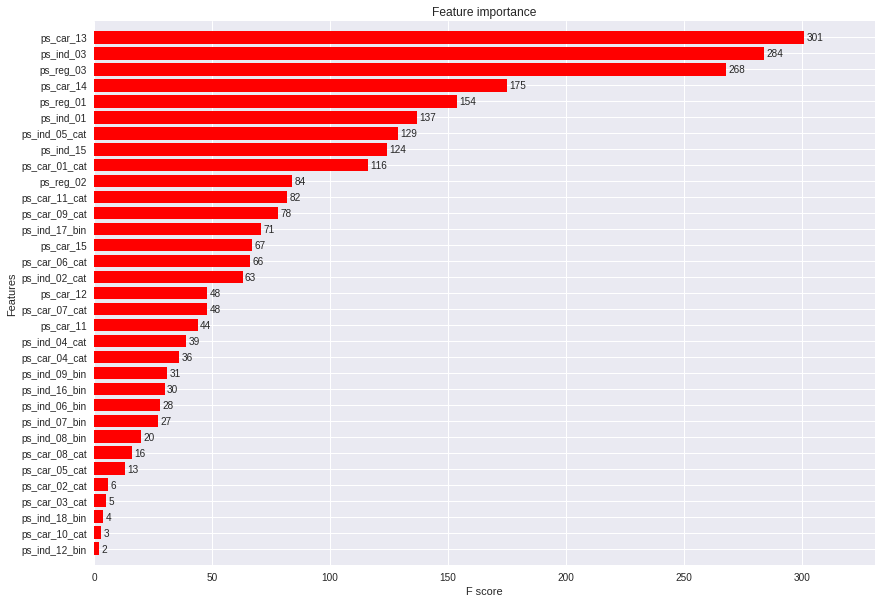

In [83]:
fig,ax = plt.subplots(figsize=(14,10))
xgb.plot_importance(xg_model,ax=ax,height=0.8,color='r')
#plt.tight_layout()
plt.show()

# Predict for unsen data set

In [82]:
y_pred = pred_xgb*0.6+ pred_lgb*0.4
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
#submit.to_csv('lr_porto.csv',index=False)
submit.to_csv('lr_porto.csv.gz',index=False,compression='gzip') 

# Thank you for visiting